In [4]:
# -*- coding: utf-8 -*-
import json
import time
import math

import tushare as ts
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("/Users/vidalicious/Documents/python workspace")

import midas.core.analyzer.api as api

import midas.core.data.models as models
from midas.core.data.engine import main_session
import midas.bin.env as env
import shutil
import os

COL_IS_MEDICAL = 'COL_IS_MEDICAL'
COL_LASTPRICE = 'COL_LASTPRICE'
COL_FLOAT_HOLDERS = 'COL_FLOAT_HOLDERS'

sampling_count = 200

/Users/vidalicious/Documents/python_env/pyenv/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3719, "'utf8' is currently an alias for the character set UTF8MB3, but will be an alias for UTF8MB4 in a future release. Please consider using UTF8MB4 in order to be unambiguous.")
  result = self._query(query)


In [5]:
offset = 0
daily001 = main_session.query(models.DailyPro).filter(models.DailyPro.ts_code == '000001.SZ').order_by(models.DailyPro.trade_date.desc()).all()
LAST_MARKET_DATE = daily001[offset].trade_date

data_frame = DataFrame()
for i, stock_basic in enumerate(main_session.query(models.StockBasicPro).all()):
    try:
        for key in models.StockBasicPro.keys:
            data_frame.loc[i, key] = getattr(stock_basic, key)

        data_frame.loc[i, COL_IS_MEDICAL] = api.is_medical(stock_basic.industry)

        daily = main_session.query(models.DailyPro).filter(models.DailyPro.ts_code == stock_basic.ts_code,
                                                           models.DailyPro.trade_date <= LAST_MARKET_DATE).order_by(
            models.DailyPro.trade_date.desc()).limit(sampling_count).all()
        data_frame.loc[i, COL_LASTPRICE] = daily[0].close

        holders = main_session.query(models.FloatHolderPro).filter(models.FloatHolderPro.ts_code == stock_basic.ts_code).all()
        h_list = []
        for item in holders:
            h_list.append(item.holder_name)
        data_frame.loc[i, COL_FLOAT_HOLDERS] = '\n'.join(h_list)

    except Exception as e:
        print('exception in index:{index} {code} {name}'.format(index=i, code=stock_basic.ts_code, name=stock_basic.name))
        continue
    print('##### medical ergodic {i} #####'.format(i=i))

##### medical ergodic 0 #####
##### medical ergodic 1 #####
##### medical ergodic 2 #####
##### medical ergodic 3 #####
##### medical ergodic 4 #####
##### medical ergodic 5 #####
##### medical ergodic 6 #####
##### medical ergodic 7 #####
##### medical ergodic 8 #####
##### medical ergodic 9 #####
##### medical ergodic 10 #####
##### medical ergodic 11 #####
##### medical ergodic 12 #####
##### medical ergodic 13 #####
##### medical ergodic 14 #####
##### medical ergodic 15 #####
##### medical ergodic 16 #####
##### medical ergodic 17 #####
##### medical ergodic 18 #####
##### medical ergodic 19 #####
##### medical ergodic 20 #####
##### medical ergodic 21 #####
exception in index:22 000029.SZ 深深房A
##### medical ergodic 23 #####
##### medical ergodic 24 #####
##### medical ergodic 25 #####
##### medical ergodic 26 #####
##### medical ergodic 27 #####
##### medical ergodic 28 #####
##### medical ergodic 29 #####
##### medical ergodic 30 #####
##### medical ergodic 31 #####
##### medica

In [7]:
data_frame = data_frame[
                        (data_frame[COL_IS_MEDICAL] == True)
                       ]

data_frame = data_frame.sort_values(by=COL_LASTPRICE, ascending=True).reset_index(drop=True)

In [8]:
data_frame

,ts_code,symbol,name,industry,COL_IS_MEDICAL,COL_LASTPRICE,COL_FLOAT_HOLDERS
0,002219.SZ,002219,*ST恒康,中成药,True,1.44,四川产业振兴发展投资基金有限公司\n长安基金-工商银行-华鑫信托-鑫康财富3号单一资金信托\...
1,000509.SZ,000509,*ST华塑,医疗保健,True,1.59,
2,000806.SZ,000806,*ST银河,生物制药,True,1.77,
3,002102.SZ,002102,ST冠福,化学制药,True,1.93,
4,600691.SH,600691,阳煤化工,农药化肥,True,1.94,云南国际信托有限公司-源盛恒瑞21号集合资金信托计划
...,...,...,...,...,...,...,...
379,002821.SZ,002821,凯莱英,生物制药,True,228.71,招商银行股份有限公司-兴全合宜灵活配置混合型证券投资基金(LOF)\n香港中央结算有限公司(...
380,688016.SH,688016,心脉医疗,医疗保健,True,292.98,中国工商银行股份有限公司-万家自主创新混合型证券投资基金\n交通银行股份有限公司-万家行业优...
381,300760.SZ,300760,迈瑞医疗,医疗保健,True,294.35,香港中央结算有限公司(陆股通)\n全国社保基金一零二组合
382,000661.SZ,000661,长春高新,生物制药,True,388.20,招商银行股份有限公司-鹏华价值成长混合型证券投资基金\n香港中央结算有限公司(陆股通)\n中...


In [68]:
def pdf_plot(data_frame, last_date):
    data_frame = data_frame[:20]
    
    columns = 2
    rows = math.ceil(len(data_frame) / columns)
    
    plt.figure(figsize=(columns * 10, rows * 10 / 2))
    sns.set(style="whitegrid")
    for i in range(len(data_frame)):
        ts_code = data_frame.loc[i, 'ts_code']
        name = data_frame.loc[i, 'name']
        plt.subplot(rows, columns, i+1)
        plot_only(ts_code=ts_code, name=name, last_date=last_date)
#             pdf.savefig()
#             plt.clf()
    plt.tight_layout()
    plt.savefig('../../buffer/medical_ergodic/{date}_medical_ergodic.png'.format(date=last_date))


def plot_only(ts_code, name, last_date):
    daily = main_session.query(models.DailyPro).filter(models.DailyPro.ts_code == ts_code,
                                                       models.DailyPro.trade_date <= last_date).order_by(
        models.DailyPro.trade_date.desc()).limit(sampling_count).all()

    data = [item.close for item in daily][60::-1]
    data =  pd.DataFrame(data, columns=[ts_code])

    plt.title('{ts_code} {name}'.format(ts_code=ts_code, name=name), fontsize=100, fontproperties='Heiti TC')
    sns.lineplot(data=data, palette="tab10", linewidth=1.5)
    # plt.clf()
    print('plot {ts_code} {name}'.format(ts_code=ts_code, name=name))

plot 002219.SZ *ST恒康
plot 000509.SZ *ST华塑
plot 000806.SZ *ST银河
plot 002102.SZ ST冠福
plot 600691.SH 阳煤化工
plot 002470.SZ 金正大
plot 300247.SZ 融捷健康
plot 000422.SZ ST宜化
plot 600518.SH ST康美
plot 600470.SH *ST六化
plot 600423.SH ST柳化
plot 002496.SZ *ST辉丰
plot 600227.SH 圣济堂
plot 600530.SH *ST交昂
plot 300108.SZ 吉药控股
plot 002162.SZ 悦心健康
plot 600090.SH 同济堂
plot 002437.SZ 誉衡药业
plot 600252.SH 中恒集团
plot 600664.SH 哈药股份


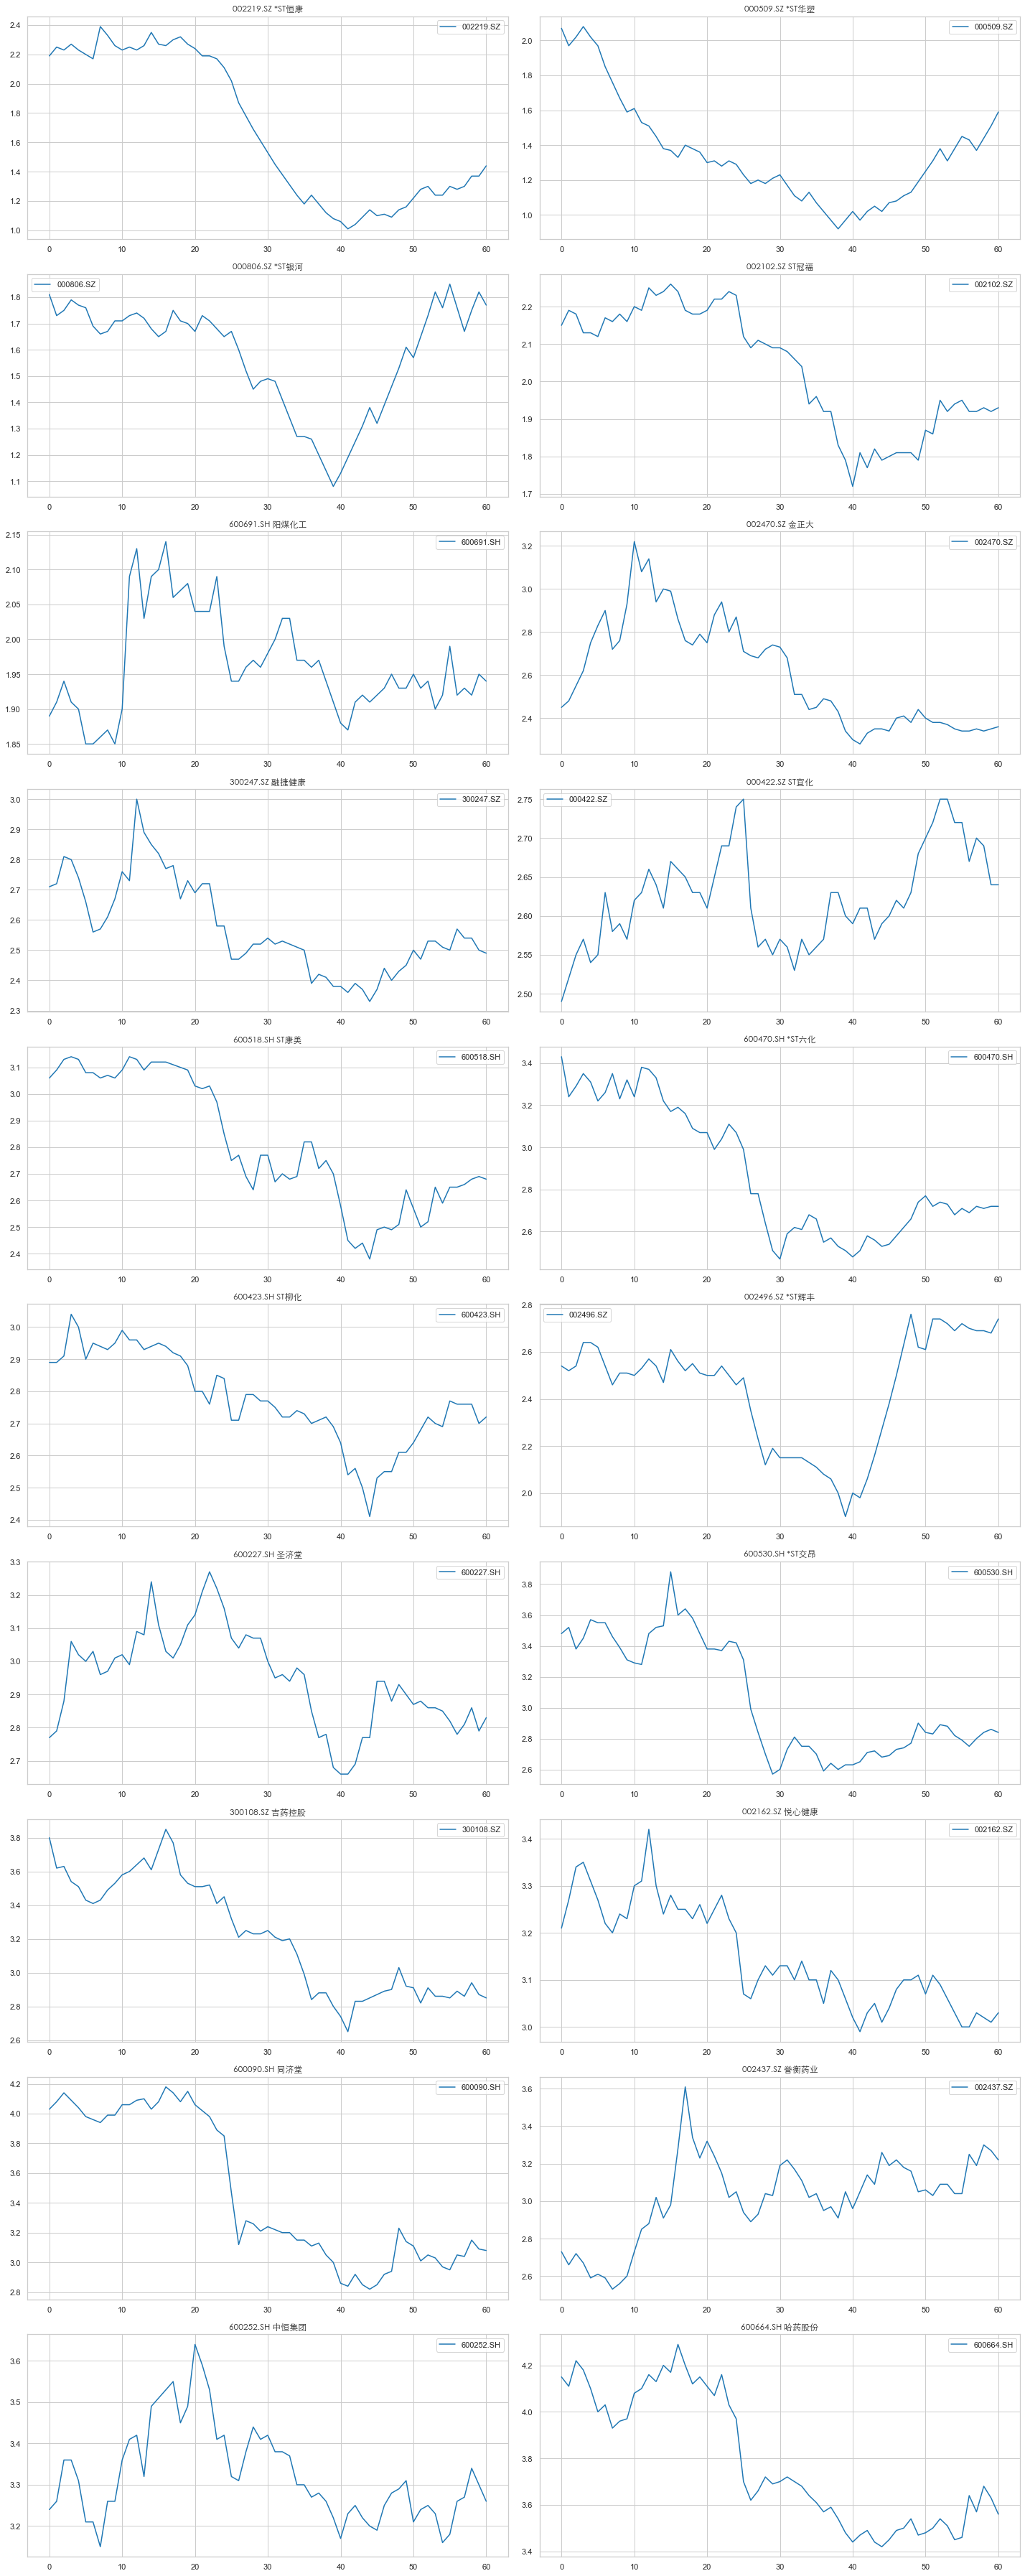

In [69]:
pdf_plot(data_frame=data_frame, last_date=LAST_MARKET_DATE)

In [67]:
2 ** 16

65536